# **Comparing and Clustering Neighborhoods in London and Paris**

Veronique Labeau

January 3rd, 2021

# **Introduction**

In this project, we will explore, segment and cluster the neighborhoods of two large European cities: **London**, the capital of England, and **Paris**, the capital of France.
Both London and Paris are found at the heart of two great European nations. They are quite popular as vacation destinations for people all around the world. They are diverse and multicultural, and offer a wide variety of experiences that are particularly sought after. 
While London is the capital of England, it is also the largest city within the country. The city stands on River Thames in South East England, with its history stretching back to the Roman times.
On the other hand, Paris, the capital of France, is in the north-central part of the nation. Like London, the city also stands along a river, commonly known as the Seine River. Paris has a rich European history and is regarded to be a global center for culture, fashion, art, and gastronomy

## **Business Problem**

Our goal here is to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. The objective is to help tourists to choose their destinations depending on the experiences that the neighbourhoods of each city have to offer and what they would like to do.
This model will also help people to make decisions if they are thinking about migrating to London or Paris or even if they wish to relocate neighbourhoods within the city. Our findings will help stakeholders make informed decisions and address any concerns they have, including the different kinds of cuisines, provision stores and what the city has to offer.

## **Methodology**

After dowloading and cleaning the datasets for both cities, we will proceed as follows:
- Convert addresses into their equivalent latitude and longitude values. 
- Use the **Foursquare API** to explore neighborhoods in both cities. 
- Explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the **k-Means** clustering algorithm to complete this task.
- Finally, we will use the _Folium_ library to visualize the neighborhoods in London and Paris cities and their emerging clusters.

## **Table of Contents**

1. [Part 1 - Data Description and Acquisition](#paragraph1)
1.1 London Dataset
1.2 Paris Dataset
2. [Part 2 - Explore and cluster London and Paris neighborhoods](#paragraph2)
2.1 Visualizing the neighborhoods of London and Paris
2.2 Foursquare - Explore London and Paris Neighborhoods
2.3 One Hot Encoding
2.4 k-Means Cluster Neighborhoods for London and Paris
2.5 Examine Clusters for London and Paris
3. [Part 3 - Results Analysis and Answer Business Problem](#paragraph3)
3.1 Most common venues by city
3.2 Venue Categories that exist in more Neighborhoods
3.3 Rare Categories in both cities
3.4 Most popular venues for London and Paris

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
! pip install geopy

     |████████████████████████████████| 112kB 5.9MB/s eta 0:00:01


In [2]:
pip install bs4

     |████████████████████████████████| 122kB 6.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary packages
from bs4 import BeautifulSoup
import re

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from IPython.display import HTML

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


# **Part 1 - Data Description and Acquisition** <a name="paragraph1"></a>

**Goal**: Build a dataframe for both Paris and London neighborhoods along with the borough name and neighborhood name. For both London and Paris neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the respective neighborhoods of the cities.

We will be required to scrape the Wikipedia pages for both datasets and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format. Each dataframe will consist of four columns:
- Borough
- Neighborhood
- Latitude
- Longitude

## **1.1 London Dataset**
Greater London has a total of 32 boroughs and and the City of London. To explore, analyze and segment them, their longitude and latitude will be added using the link to the following dataset:

- We will scrape London data from the Wikipedia page https://en.wikipedia.org/wiki/List_of_areas_of_London, which has information about all the boroughs.
- Locations coordinates: Since this Wikipedia page lacks information about geographical locations, we will use ArcGIS API to complete the dataset with the longitude and latitude data for the boroughs of London.


### _1.1.1 Data Collection and Preprocessing_

To create London dataframe:
- We will process only on the boroughs that contains the word London in the postal town column.
- We will remove any footnote reference numbers with [] in the borough names.
- We will add the coordinates for each London neighborhood.
- Finally, create London dataframe for our study.

In [4]:
# Site URL London
url="https://en.wikipedia.org/wiki/List_of_areas_of_London"

# Make a GET request to fetch the raw HTML Content
html_content = requests.get(url).text

# Parse HTML code
soup = BeautifulSoup(html_content, "html.parser")
#print(soup.prettify())

# Find tables on site
gdp = soup.find_all("table",attrs={"class" : "wikitable"})
print("Number of tables found: " , len(gdp))

Number of tables found:  1


Let's scrape the table and process the data as described above.

In [5]:
tablepc = gdp[0]
# Head as column names
body = tablepc.find_all("tr")
# Head column names, 1st item of body list
head = body[0]
body_rows = body[1:]  #all other items are rest of rows

# Columns headings - Declare empty list for Columns names
headings=[]
for item in head.find_all("th"):
    #convert th elements to text and strip "\n"
    item = (item.text).rstrip("\n")
    # Drop footnote superscripts in brackets
    item =  re.sub('(\xa0)|(\n)|','',item)
    # append clean column name to headings
    headings.append(item)
print( headings)

# Detail rows - Loop through rest of rows
all_rows = []
for row_num in range(len(body_rows)):
    row=[]
    for row_item in body_rows[row_num].find_all("td"):
        # row_item.txt removes tags from entries
        # following regex is to remove \xa0 and \n and comma from row_item.text
        # xa0 encodes flag, \n is newline and comma separates thousand in nmubers
        aa =  re.sub('(\xa0)|(\n)|','',row_item.text)
        # Drop footnote superscripts in brackets
        aa = re.sub(r'\[.*?\]+', '', aa)
        # append aa to row
        row.append(aa)
    # append on row to all rows
    all_rows.append(row)

# Use data on "all_rows" and headings to create dataframe
London_raw=pd.DataFrame(data=all_rows, columns=headings)
London_raw.head()

['Location', 'Londonborough', 'Post town', 'Postcodedistrict', 'Dialcode', 'OS grid ref']


,Location,Londonborough,Post town,Postcodedistrict,Dialcode,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### _1.1.2 Feature Selection and Engineering_

Only the boroughs with the word _London_ in the _Post-town_ field will be used for our search of location. Therefore, all the non-post-town are dropped

In [6]:
# Filtering data on London
London_raw = London_raw[London_raw['Post town'].str.contains('LONDON')]
London_raw.head()

,Location,Londonborough,Post town,Postcodedistrict,Dialcode,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
6,Aldgate,City,LONDON,EC3,020,TQ334813
7,Aldwych,Westminster,LONDON,WC2,020,TQ307810
9,Anerley,Bromley,LONDON,SE20,020,TQ345695


Delete any columns that will not be used in our project and rename the renaiming ones appropriately.

In [7]:
# Keep only columns that will be used for the current project
London_raw = London_raw[['Location', 'Londonborough', 'Postcodedistrict',]].reset_index(drop=True)

# Rename related columns
London_raw.columns = ['Neighborhood', 'Borough','Postal code']

# Re-order Columns
London_raw = London_raw[['Borough','Neighborhood','Postal code']]

Let's remove the whitesapaces at the start of some of the postcodes 

In [8]:
# Strips whitespaces before postal code
London_raw['Postal code'] = London_raw['Postal code'].str.strip()
London_raw['Borough'] = London_raw['Borough'].str.strip()

In [9]:
London_raw.head()

,Borough,Neighborhood,Postal code
0,"Bexley, Greenwich",Abbey Wood,SE2
1,"Ealing, Hammersmith and Fulham",Acton,"W3, W4"
2,City,Aldgate,EC3
3,Westminster,Aldwych,WC2
4,Bromley,Anerley,SE20


Let's quickly check the dimension of the dataframe

In [10]:
London_raw.shape

(309, 3)

In [11]:
London_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       309 non-null    object
 1   Neighborhood  309 non-null    object
 2   Postal code   309 non-null    object
dtypes: object(3)
memory usage: 7.4+ KB


### _1.1.3 London Neighborhoods coordinates_
Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the **Foursquare** location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In obtaining the location data of the neighborhoods, the Geocoder package is used with the **arcgis_geocoder** to obtain the latitude and longitude of the needed locations.

In [12]:
# install the Geocoder
!pip -q install geocoder

In [13]:
import geocoder

In [14]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [15]:
#Testing function
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

In [16]:
#start = time.time()
postal_codes = London_raw['Postal code']
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]
#end = time.time()

#print("Time of execution: ", end - start, "seconds")

### _1.1.4 London Dataframe_ 

Then we proceed to store the location data — latitude and longitude as follows. The obtained coordinates are then joined to df_se_top to create new data frame.

In [17]:
# Merge data frame with Latitude and Longitude
df_london= London_raw
# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_london['Latitude'] = df_se_coordinates['Latitude']
df_london['Longitude'] = df_se_coordinates['Longitude']
df_london.head(5)

,Borough,Neighborhood,Postal code,Latitude,Longitude
0,"Bexley, Greenwich",Abbey Wood,SE2,51.49245,0.12127
1,"Ealing, Hammersmith and Fulham",Acton,"W3, W4",51.51324,-0.26746
2,City,Aldgate,EC3,51.51200,-0.08058
3,Westminster,Aldwych,WC2,51.51651,-0.11968
4,Bromley,Anerley,SE20,51.41009,-0.05683


In [18]:
# Drop Postal code column
df_london.drop(columns =['Postal code'], inplace = True)
df_london.head()

,Borough,Neighborhood,Latitude,Longitude
0,"Bexley, Greenwich",Abbey Wood,51.49245,0.12127
1,"Ealing, Hammersmith and Fulham",Acton,51.51324,-0.26746
2,City,Aldgate,51.51200,-0.08058
3,Westminster,Aldwych,51.51651,-0.11968
4,Bromley,Anerley,51.41009,-0.05683


Let's confirm the number of boroughs and neighborhodds for the DataFrame of London.

In [19]:
# Print the number of rows of the dataframe
print('London dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_london['Borough'].unique()),
        df_london.shape[0]
    )
)

London dataframe has 50 boroughs and 309 neighborhoods.


## **1.2 Paris Dataset**

Paris has in total 20 boroughs (called _arrondissements_ in French) and 80 neighborhoods (called _quartiers_ in French). To explore, analyze and segment neighborhoods, longitude and latitude of each neighbor and borough will be added using the following links:

- Paris Boroughs: https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e
- Paris Neighborhoods: https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin


### 1.2.1 Paris - Data Collection & Preprocessing

To create Paris dataframe:

- We will process only on the boroughs of _Paris_ since the link that we will use contains all the regions of France.
- We will add the coordinates for each Paris neighborhood.
- Finally, create Paris dataframe for our study.

In [20]:
# Data for Paris Neighborhoods
!wget -q -O 'correspondances-code-insee-code-postal.json' https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e
print("Paris Data Downloaded!")

Paris Data Downloaded!


In [21]:
# Load and explore the data - Next, let's load the data. 
with open('correspondances-code-insee-code-postal.json') as json_data:
    paris_data = json.load(json_data)

# Let's take a quick look at the data. 
paris_data[0]

{'datasetid': 'correspondances-code-insee-code-postal',
 'recordid': '2bf36b38314b6c39dfbcd09225f97fa532b1fc45',
 'fields': {'code_comm': '645',
  'nom_dept': 'ESSONNE',
  'statut': 'Commune simple',
  'z_moyen': 121.0,
  'nom_region': 'ILE-DE-FRANCE',
  'code_reg': '11',
  'insee_com': '91645',
  'code_dept': '91',
  'geo_point_2d': [48.750443119964764, 2.251712972144151],
  'postal_code': '91370',
  'id_geofla': '16275',
  'code_cant': '03',
  'geo_shape': {'type': 'Polygon',
   'coordinates': [[[2.238024349288764, 48.735565859837095],
     [2.226414985434264, 48.75003536744732],
     [2.22450256558849, 48.75882853410981],
     [2.232859032169924, 48.76598806763034],
     [2.250043759055985, 48.761213267519565],
     [2.269288614654887, 48.76063999654954],
     [2.276145972515501, 48.75666127305422],
     [2.283691112862691, 48.748081131389654],
     [2.274517407535147, 48.74072222671912],
     [2.238024349288764, 48.735565859837095]]]},
  'superficie': 999.0,
  'nom_comm': 'VERRIERE

### _1.2.2 Feature Selection and Engineering_

With this dataset, we are extracting only the 20 _arrondissements_ of Paris and ID of their related neighborhoods.

In [22]:
# define the dataframe columns
column_names = ['Borough', 'IdNeighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Then let's loop through the data and fill the dataframe one row at a time. 
for data in paris_data:
    borough = neighborhood_name = data['fields']['nom_comm'] 
    neighborhood_name = data['fields']['code_comm']
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'IdNeighborhood': neighborhood_name}, ignore_index=True)

# Extracting only PARIS arrondissements
paris_arrondissement = neighborhoods[neighborhoods['Borough'].str.contains('PARIS-')].reset_index(drop=True)

Let's now retrieve the arrondissement which is the last 2 digits of ID Neighborhood.

In [23]:
# Retrieve Arrondissement - Keep only last 2 digits of ID Neighborhood
paris_arrondissement['IdNeighborhood']= paris_arrondissement['IdNeighborhood'].str[-2:]

# Convert the Id to numeric for later
paris_arrondissement['IdNeighborhood']=paris_arrondissement['IdNeighborhood'].astype(str).astype(int)

# Re-order Columns
paris_arrondissement = paris_arrondissement[['Borough','IdNeighborhood']]

# Display results
paris_arrondissement.head()

,Borough,IdNeighborhood
0,PARIS-9E-ARRONDISSEMENT,9
1,PARIS-2E-ARRONDISSEMENT,2
2,PARIS-11E-ARRONDISSEMENT,11
3,PARIS-15E-ARRONDISSEMENT,15
4,PARIS-19E-ARRONDISSEMENT,19


### 1.2.3 Paris - Neighoroughs and Coordinates

Now that we have the Borough (arrondissements), let's now continue the scraping to complete the data with the neighborhoods and coordinates.

In [24]:
# Data for Paris Neighborhoods (Quartiers)
!wget -q -O 'quartier_paris.json' https://www.data.gouv.fr/fr/datasets/r/fd5a9c4a-0a7c-43aa-a986-4434a4d0707f
print("Paris Neighborhood Data Downloaded!")

Paris Neighborhood Data Downloaded!


In [25]:
# Load and explore the data for quartier_paris
with open('quartier_paris.json') as json_data:
    quartier_data = json.load(json_data)

# Let's take a quick look at the data. 
quartier_data[0]

{'datasetid': 'quartier_paris',
 'recordid': '07d0efa6ba9c4030e2d379ad164ef90bae1d8933',
 'fields': {'n_sq_qu': 750000020,
  'perimetre': 2892.94406823,
  'geom_x_y': [48.8490447659, 2.34574660019],
  'c_qu': 20,
  'surface': 433197.79244055,
  'l_qu': 'Sorbonne',
  'geom': {'type': 'Polygon',
   'coordinates': [[[2.349244542106854, 48.84451631667142],
     [2.348884567450511, 48.84449223012391],
     [2.34809164269284, 48.84442882656308],
     [2.346613785116703, 48.84479701923843],
     [2.34548425335897, 48.845073369325895],
     [2.345202960559096, 48.845157703744164],
     [2.344558002547573, 48.845499475301175],
     [2.344271720729649, 48.84565187168997],
     [2.34415130046344, 48.8457150383324],
     [2.344029814192932, 48.845779621795316],
     [2.343673349834949, 48.8459320231181],
     [2.343560922816368, 48.845958522009774],
     [2.343410954995123, 48.845990392604044],
     [2.343093549458029, 48.846061599129015],
     [2.34302850018478, 48.84607609307574],
     [2.342778

In [26]:
# define the dataframe columns
quartiercolumn_names = ['IdNeighborhood', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
paris_quartiers = pd.DataFrame(columns=quartiercolumn_names)

# Then let's loop through the data and fill the dataframe one row at a time. 
for quart in quartier_data:
    quartier =  quart['fields']['c_ar'] 
    neighborhood_name = quart['fields']['l_qu']
        
    neighborhood_latlon = quart['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    paris_quartiers = paris_quartiers.append({'IdNeighborhood': quartier,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [27]:
# Convert the Id to numeric for later
paris_quartiers['IdNeighborhood']=paris_quartiers['IdNeighborhood'].astype(str).astype(int)
paris_quartiers.head()

,IdNeighborhood,Neighborhood,Latitude,Longitude
0,5,Sorbonne,48.849045,2.345747
1,9,Saint-Georges,48.879934,2.332850
2,9,Chaussée-d'Antin,48.873547,2.332269
3,1,Palais-Royal,48.864660,2.336309
4,9,Rochechouart,48.879812,2.344861


### _1.2.4 Paris Dataframe_

In [28]:
# Merge Arrondissement and Quartiers
df_paris= pd.merge(left=paris_arrondissement, right=paris_quartiers, how="left",left_on='IdNeighborhood', right_on='IdNeighborhood')

# Drop Id Neighborhood column
df_paris.drop(columns =['IdNeighborhood'], inplace = True)

# Display dataframe after cleaning
df_paris.head()

,Borough,Neighborhood,Latitude,Longitude
0,PARIS-9E-ARRONDISSEMENT,Saint-Georges,48.879934,2.332850
1,PARIS-9E-ARRONDISSEMENT,Chaussée-d'Antin,48.873547,2.332269
2,PARIS-9E-ARRONDISSEMENT,Rochechouart,48.879812,2.344861
3,PARIS-9E-ARRONDISSEMENT,Faubourg-Montmartre,48.873935,2.343253
4,PARIS-2E-ARRONDISSEMENT,Gaillon,48.869307,2.333432


Let's check that Paris dataframe has 20 boroughs and 80 neighborhoods.

In [29]:
print('Paris dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_paris['Borough'].unique()),
        df_paris.shape[0]
    )
)

Paris dataframe has 20 boroughs and 80 neighborhoods.


------------------------------------------------------

# **Part 2 - Explore and cluster the neighborhoods** <a name="paragraph3"></a>

Let's download all the dependencies that we will need.

In [30]:
! pip install folium

In [31]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


Now that our datasets are ready, using the Folium package, we can visualize the maps of London and Paris with the neighbourhoods that we collected.

## 2.1. Visualizing the neighborhoods of London and Paris

We will be using the geopy library to get the latitude and longitude values of London and Paris.
In order to define an instance of the geocoder, we need to define a user_agent.

### _2.1.1 London Map_

In [32]:
# Let's name our agent london_explorer
address = 'London, Uk'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


Now, let's create a map of London with neighborhoods superimposed on top.

In [33]:
# dropping null value columns to avoid errors 
df_london.dropna(inplace = True) 

In [34]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(
        df_london['Latitude'], 
        df_london['Longitude'], 
        df_london['Borough'], 
        df_london['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        ##fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### _2.1.2. Paris Map_

In [35]:
# Let's name our agent paris_explorer
address_paris = 'Paris, fr'

geolocator = Nominatim(user_agent="london_explorer")
location_paris= geolocator.geocode(address_paris)
latitude_paris = location_paris.latitude
longitude_paris = location_paris.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude_paris, longitude_paris))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [36]:
# dropping null value columns to avoid errors 
df_paris.dropna(inplace = True) 

In [37]:
# create map of London using latitude and longitude values
map_paris = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(
        df_paris['Latitude'], 
        df_paris['Longitude'], 
        df_paris['Borough'], 
        df_paris['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        ##fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)
    
map_paris

## 2.2 Foursquare - Explore London and Paris Neighborhoods

Next, we are going to start utilizing the **Foursquare API** to explore the neighborhoods of cities and segment them.

### _2.2.1 Define Foursquare Credentials and Version_

In [42]:
#CLIENT_ID = 'UJEMJH4MITR4GPWKODNA5RA2EEYXAU50PJV1X4B4JNS1QEST' # your Foursquare ID
#CLIENT_SECRET = 'E0MEKF3ADGWR2USWXL424R2HPQ5WZGUZPGFJA3AW001OUAJH' # your Foursquare Secret
#CLIENT_SECRET = 'BPQWTFACP21SMIG3BS2FV32LNXWG4J52TICK34GAD1HO0HUF' # your Foursquare Secret

CLIENT_ID = 'I1YXGQ0NAVDXE3LOZPYMH15ENQEPJJQHWVUKMRJINAHUG22Y' # your Foursquare ID
CLIENT_SECRET = 'BPQWTFACP21SMIG3BS2FV32LNXWG4J52TICK34GAD1HO0HUF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Variables needed
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Let's create a function to get the venue categories

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


### _2.2.3 London - Exploring all neighborhoods_

Let's run the above function on each neighborhood and create a new dataframe called _london_venues_.

In [44]:
london_venues = getNearbyVenues(names=df_london['Neighborhood'],
                                   latitudes=df_london['Latitude'],
                                   longitudes=df_london['Longitude']
                                  )


Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnet Gate
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Bexleyheath (also Bexley New Town)
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Bromley (also Bromley-by-Bow)
Brompton
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Church End
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Custom House
Dalston
De Beauvoir Town
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham


In [45]:
### Let's check the size of the resulting dataframe
print(london_venues.shape)
london_venues.head()

(10460, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492826,0.120524,Supermarket
2,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
3,Abbey Wood,51.49245,0.12127,Abbey Wood Railway Station (ABW),51.490825,0.123432,Train Station
4,Abbey Wood,51.49245,0.12127,Bean @ Work,51.491172,0.120649,Coffee Shop


Let's check how many venues were returned for each neighborhood group by _Venue Category_

In [46]:
london_venues.groupby('Venue Category').max()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,St Giles,51.51651,-0.11968,James Smith & Sons,51.516902,-0.126843
Adult Boutique,Shoreditch,51.52969,-0.08697,Sh! Women's Erotic Emporium,51.527102,-0.083728
African Restaurant,Wormwood Scrubs,51.52587,-0.08808,Red Sea Restaurant,51.523967,-0.080917
American Restaurant,Turnpike Lane,51.61780,0.02795,Spielburger,51.617790,0.024169
Antique Shop,St Giles,51.51651,-0.11968,The London Silver Vaults,51.517145,-0.112608
Arcade,St Giles,51.51651,-0.11968,Novelty Automation,51.519793,-0.117055
Arepa Restaurant,Haggerston,51.52669,-0.06257,Arepa & Co,51.528670,-0.056137
Argentinian Restaurant,Tower Hill,51.61568,-0.08058,Zoilo,51.613899,-0.084629
Art Gallery,Woodford Green,51.52669,-0.06257,The Wallace Collection,51.525375,-0.055778


Let's find out how many unique categories can be curated from all the returned venues

In [47]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 302 uniques categories.


### _2.2.3 Paris - Exploring all neighborhoods_

Let's run the same function on each neighborhood and create a new dataframe called _paris_venues_.

In [48]:
paris_venues = getNearbyVenues(names=df_paris['Neighborhood'],
                                   latitudes=df_paris['Latitude'],
                                   longitudes=df_paris['Longitude']
                                  )

Saint-Georges
Chaussée-d'Antin
Rochechouart
Faubourg-Montmartre
Gaillon
Mail
Bonne-Nouvelle
Vivienne
Folie-Méricourt
Roquette
Saint-Ambroise
Sainte-Marguerite
Javel
Grenelle
Necker
Saint-Lambert
Pont-de-Flandre
Combat
Villette
Amérique
Charonne
Saint-Fargeau
Belleville
Père-Lachaise
Arts-et-Métiers
Archives
Sainte-Avoie
Enfants-Rouges
Notre-Dame-des-Champs
Monnaie
Odéon
Saint-Germain-des-Prés
Grandes-Carrières
La Chapelle
Clignancourt
Goutte-d'Or
Arsenal
Saint-Gervais
Saint-Merri
Notre-Dame
Palais-Royal
Halles
Place-Vendôme
Saint-Germain-l'Auxerrois
Epinettes
Ternes
Batignolles
Plaine de Monceaux
Faubourg-du-Roule
Madeleine
Champs-Elysées
Europe
Salpêtrière
Maison-Blanche
Croulebarbe
Gare
Bercy
Picpus
Quinze-Vingts
Bel-Air
Sorbonne
Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Porte-Saint-Martin
Porte-Saint-Denis
Hôpital-Saint-Louis
Saint-Vincent-de-Paul
Muette
Chaillot
Auteuil
Porte-Dauphine
Ecole-Militaire
Saint-Thomas-d'Aquin
Invalides
Gros-Caillou
Petit-Montrouge
Plaisance
Montparna

In [49]:
### Let's check the size of the resulting dataframe
print(paris_venues.shape)
paris_venues.head()

(5114, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Georges,48.879934,2.33285,Les Canailles,48.879281,2.334570,French Restaurant
1,Saint-Georges,48.879934,2.33285,Causses,48.880152,2.335348,Deli / Bodega
2,Saint-Georges,48.879934,2.33285,Albert,48.878216,2.332229,Bistro
3,Saint-Georges,48.879934,2.33285,Lalà - La Lasagneria,48.881026,2.334610,Italian Restaurant
4,Saint-Georges,48.879934,2.33285,L'Affineur'Affiné,48.879944,2.335639,Cheese Shop


Let's check how many venues were returned for each neighborhood group by _Venue Category_

In [50]:
paris_venues.groupby('Venue Category').max()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,Place-Vendôme,48.867019,2.328582,Longchamp,48.868013,2.328925
Afghan Restaurant,Saint-Ambroise,48.862345,2.376118,Afghanistan,48.862327,2.379999
African Restaurant,Saint-Vincent-de-Paul,48.895556,2.387549,Waly Fay,48.897209,2.390209
Alsatian Restaurant,Saint-Merri,48.858521,2.351667,L'Alsacien,48.858275,2.350381
American Restaurant,Villette,48.895556,2.384777,Ralph's,48.896707,2.384141
Antique Shop,Vivienne,48.873935,2.343253,Hôtel des Ventes Drouot,48.873061,2.340101
Arcade,Vivienne,48.873935,2.343253,La Tête dans les Nuages,48.871882,2.339288
Arepa Restaurant,Grandes-Carrières,48.892578,2.345979,Bululú,48.890984,2.339592
Argentinian Restaurant,Saint-Victor,48.876008,2.368123,Loco,48.873772,2.371164


Let's find out how many unique categories can be curated from all the returned venues

In [51]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 303 uniques categories.


## 2.3. One Hot Encoding

Since we are trying to find out what are the different kinds of venue categories present in each neighbourhood and then calculate the top 10 common venues to base our similarity on, we use the One Hot Encoding to work with our categorical data type of the venue categories. This helps to convert the categorical data into numeric data.

We will not be using label encoding in this situation since label encoding might cause our machine learning model to have a bias or a sort of ranking which we are trying to avoid by using One Hot Encoding.

We perform one-hot encoding and then calculate the mean of the grouped venue categories for each of the neighbourhoods.


First, let's write a function to sort the venues in descending order. This function will be used later for both cities.

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### _2.3.1 London - Top10 Venue Category_

We first convert _Venue Category_ variable into dummy variables.

In [53]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

# Quick look
london_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Donut Shop,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,T

In [54]:
# And let's examine the new dataframe size
london_onehot.shape

(10460, 303)

**Venue categories mean value**

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [55]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
# Quick look
london_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Donut Shop,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,T

In [56]:
# Let's confirm the new size
london_grouped.shape

(307, 303)

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [58]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Coffee Shop,Train Station,Convenience Store,Platform,Historic Site,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market
1,Acton,Grocery Store,Train Station,Park,Indian Restaurant,Breakfast Spot,Deli / Bodega,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
2,Aldgate,Hotel,Gym / Fitness Center,Restaurant,Salad Place,Coffee Shop,Garden,Italian Restaurant,Pub,Cocktail Bar,Asian Restaurant
3,Aldwych,Pub,Sandwich Place,Theater,Hotel,Japanese Restaurant,Café,Bakery,Clothing Store,Coffee Shop,Chinese Restaurant
4,Anerley,Supermarket,Grocery Store,Convenience Store,Hotel,Fast Food Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant


### _2.3.2 Paris - Top10 Venue Category_

We first convert _Venue Category_ variable into dummy variables.

In [59]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

# Quick look
paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Syrian Rest

In [60]:
# And let's examine the new dataframe size
paris_onehot.shape

(5114, 304)

**Venue categories mean value for Paris**

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
# Quick look
paris_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Syrian Rest

In [62]:
# Let's confirm the new size
paris_grouped.shape

(80, 304)

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns_paris = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns_paris.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns_paris.append('{}th Most Common Venue'.format(ind+1))

In [64]:
# create a new dataframe
paris_neighborhoods_venues_sorted = pd.DataFrame(columns=columns_paris)
paris_neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    paris_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

paris_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Pool,French Restaurant,Supermarket,Bistro,Bed & Breakfast,Plaza,Park,Café,Falafel Restaurant,English Restaurant
1,Archives,French Restaurant,Hotel,Coffee Shop,Clothing Store,Art Gallery,Bar,Italian Restaurant,Bistro,Bookstore,Cocktail Bar
2,Arsenal,French Restaurant,Hotel,Gastropub,Park,Plaza,Italian Restaurant,Tapas Restaurant,Pedestrian Plaza,Seafood Restaurant,Boat or Ferry
3,Arts-et-Métiers,French Restaurant,Hotel,Cocktail Bar,Wine Bar,Italian Restaurant,Chinese Restaurant,Coffee Shop,Bar,Restaurant,Vietnamese Restaurant
4,Auteuil,Tennis Court,Stadium,Garden,Sporting Goods Shop,Racecourse,Outdoors & Recreation,Botanical Garden,Museum,Office,French Restaurant


## **2.4. _k-Means_ Cluster Neighborhoods for London and Paris**

Run _k_-means to cluster the neighborhood into 5 clusters to make it easier to analyze.

### _2.4.1 London - Cluster Neighborhoods_

In [65]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)
kmeans_london

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

**Labelling Clustered Data**

In [66]:
# check cluster labels generated for each row in the dataframe
kmeans_london.labels_[0:10] 

array([4, 4, 3, 3, 4, 3, 3, 3, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [67]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_london.labels_)

In [68]:
london_merged = df_london

# merge london_grouped with london dataframe to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bexley, Greenwich",Abbey Wood,51.49245,0.12127,4,Supermarket,Coffee Shop,Train Station,Convenience Store,Platform,Historic Site,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market
1,"Ealing, Hammersmith and Fulham",Acton,51.51324,-0.26746,4,Grocery Store,Train Station,Park,Indian Restaurant,Breakfast Spot,Deli / Bodega,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
2,City,Aldgate,51.51200,-0.08058,3,Hotel,Gym / Fitness Center,Restaurant,Salad Place,Coffee Shop,Garden,Italian Restaurant,Pub,Cocktail Bar,Asian Restaurant
3,Westminster,Aldwych,51.51651,-0.11968,3,Pub,Sandwich Place,Theater,Hotel,Japanese Restaurant,Café,Bakery,Clothing Store,Coffee Shop,Chinese Restaurant
4,Bromley,Anerley,51.41009,-0.05683,4,Supermarket,Grocery Store,Convenience Store,Hotel,Fast Food Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant


In [69]:
## Remove any NaN values to avoid errors
london_merged = london_merged.dropna(subset=['Cluster Labels'])

Finally, let's visualize the resulting clusters

In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### _2.4.2 Paris - Cluster Neighborhoods_

In [71]:
# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_paris = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)
kmeans_paris

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

**Labelling Clustered Data**

In [72]:
# check cluster labels generated for each row in the dataframe
kmeans_paris.labels_[0:10] 

array([4, 0, 1, 0, 2, 1, 4, 0, 4, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [73]:
# add clustering labels
paris_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_paris.labels_)

In [74]:
paris_merged = df_paris

# merge paris_grouped with paris dataframe to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(paris_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS-9E-ARRONDISSEMENT,Saint-Georges,48.879934,2.332850,1,Hotel,French Restaurant,Italian Restaurant,Cocktail Bar,Lounge,Comedy Club,Vietnamese Restaurant,Bistro,Café,Bakery
1,PARIS-9E-ARRONDISSEMENT,Chaussée-d'Antin,48.873547,2.332269,0,Hotel,French Restaurant,Salad Place,Italian Restaurant,Bistro,Department Store,Coffee Shop,Clothing Store,Vietnamese Restaurant,Café
2,PARIS-9E-ARRONDISSEMENT,Rochechouart,48.879812,2.344861,1,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Park,Record Shop,Restaurant,Coffee Shop,Wine Bar
3,PARIS-9E-ARRONDISSEMENT,Faubourg-Montmartre,48.873935,2.343253,1,French Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Gym / Fitness Center,Bar
4,PARIS-2E-ARRONDISSEMENT,Gaillon,48.869307,2.333432,4,Japanese Restaurant,Hotel,Korean Restaurant,French Restaurant,Chocolate Shop,Bakery,Wine Bar,Plaza,Coffee Shop,Pastry Shop


In [75]:
## Remove any NaN values to avoid errors
paris_merged = paris_merged.dropna(subset=['Cluster Labels'])

Finally, let's visualize the resulting clusters

In [76]:
# create map
paris_map_clusters = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(paris_map_clusters)
       
paris_map_clusters

## **3.5. Examine Clusters for London and Paris**

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### _3.5.1 London Clusters_

#### London Cluster 1

In [77]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bankside,Pub,Coffee Shop,Park,Gym / Fitness Center,Theater,Café,Sandwich Place,Argentinian Restaurant,Wine Bar,Hotel
22,Belsize Park,Café,Pub,Bakery,Museum,Ice Cream Shop,Italian Restaurant,Bistro,Bed & Breakfast,English Restaurant,Thai Restaurant
23,Bermondsey,Pub,Coffee Shop,Park,Gym / Fitness Center,Theater,Café,Sandwich Place,Argentinian Restaurant,Wine Bar,Hotel
28,Blackheath Royal Standard,Pub,Polish Restaurant,Fried Chicken Joint,Café,Fish & Chips Shop,Train Station,Grocery Store,Italian Restaurant,Hotel,Dance Studio
30,Bloomsbury,Pub,Garden,Bookstore,Coffee Shop,Café,Pizza Place,Fish & Chips Shop,Tapas Restaurant,Szechuan Restaurant,Supermarket
32,Bow,Pub,Rental Car Location,Bar,Burger Joint,Grocery Store,Light Rail Station,Locksmith,Flower Shop,Flea Market,Fishing Store
38,Bromley (also Bromley-by-Bow),Pub,Rental Car Location,Bar,Burger Joint,Grocery Store,Light Rail Station,Locksmith,Flower Shop,Flea Market,Fishing Store
40,Brondesbury,Indian Restaurant,Pub,Supermarket,Brazilian Restaurant,Café,Portuguese Restaurant,Sandwich Place,Gastropub,Fast Food Restaurant,Entertainment Service
58,Chinbrook,Pub,Polish Restaurant,Fried Chicken Joint,Café,Fish & Chips Shop,Train Station,Grocery Store,Italian Restaurant,Hotel,Dance Studio
65,Colindale,Bus Stop,Asian Restaurant,Ice Cream Shop,Pub,Hotel,Hookah Bar,Café,Coffee Shop,Supermarket,Auto Workshop


#### London Cluster 2

In [78]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Eltham,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
92,Falconwood,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
165,Longlands,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
175,Middle Park,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
181,Mottingham,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
186,New Eltham,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store
284,Well Hall,Historic Site,Bus Stop,Golf Course,Construction & Landscaping,Park,Food & Drink Shop,Food Court,Flower Shop,Flea Market,Fishing Store


#### London Cluster 3

In [79]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Blackheath,Pub,Photography Studio,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market
147,Kidbrooke,Pub,Photography Studio,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market
295,Westcombe Park,Pub,Photography Studio,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market


#### London Cluster 4

In [80]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Aldgate,Hotel,Gym / Fitness Center,Restaurant,Salad Place,Coffee Shop,Garden,Italian Restaurant,Pub,Cocktail Bar,Asian Restaurant
3,Aldwych,Pub,Sandwich Place,Theater,Hotel,Japanese Restaurant,Café,Bakery,Clothing Store,Coffee Shop,Chinese Restaurant
5,Angel,Food Truck,Coffee Shop,Pub,Gym / Fitness Center,Italian Restaurant,Park,Hotel,Vietnamese Restaurant,Turkish Restaurant,Café
6,Archway,Grocery Store,Pizza Place,Coffee Shop,Pub,Italian Restaurant,Hotel,Pet Store,Café,Fast Food Restaurant,Farmers Market
7,Arkley,Coffee Shop,Grocery Store,Juice Bar,Salon / Barbershop,Pharmacy,Café,Stationery Store,Chinese Restaurant,Train Station,Restaurant
8,Arnos Grove,Fast Food Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Sandwich Place,Dessert Shop,Supermarket,Turkish Restaurant,Café,Pharmacy
9,Balham,Grocery Store,Coffee Shop,Pub,Bakery,Fast Food Restaurant,Indian Restaurant,Burger Joint,Shop & Service,Fish & Chips Shop,Breakfast Spot
11,Barbican,Hotel,Gym / Fitness Center,Indie Movie Theater,Food Truck,Coffee Shop,Steakhouse,Art Gallery,Boxing Gym,English Restaurant,Pub
12,Barnes,Park,Farmers Market,Café,Pub,Food & Drink Shop,Breakfast Spot,Community Center,Track,Coffee Shop,Bookstore
13,Barnet Gate,Coffee Shop,Grocery Store,Juice Bar,Salon / Barbershop,Pharmacy,Café,Stationery Store,Chinese Restaurant,Train Station,Restaurant


#### London Cluster 5

In [81]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Coffee Shop,Train Station,Convenience Store,Platform,Historic Site,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market
1,Acton,Grocery Store,Train Station,Park,Indian Restaurant,Breakfast Spot,Deli / Bodega,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
4,Anerley,Supermarket,Grocery Store,Convenience Store,Hotel,Fast Food Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant
17,Beckenham,Supermarket,Grocery Store,Convenience Store,Hotel,Fast Food Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant
21,Bellingham,Grocery Store,Discount Store,Train Station,Furniture / Home Store,Turkish Restaurant,Pizza Place,Event Space,Exhibit,Falafel Restaurant,Farmers Market
25,Bexleyheath (also Bexley New Town),Supermarket,Coffee Shop,Train Station,Convenience Store,Platform,Historic Site,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market
31,Bounds Green,Indian Restaurant,Grocery Store,Park,Bar,Italian Restaurant,Food Service,Food Court,Food & Drink Shop,Flower Shop,Flea Market
33,Bowes Park,Indian Restaurant,Grocery Store,Park,Bar,Italian Restaurant,Food Service,Food Court,Food & Drink Shop,Flower Shop,Flea Market
41,Brunswick Park,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Beer Bar,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
51,Catford,Grocery Store,Discount Store,Train Station,Furniture / Home Store,Turkish Restaurant,Pizza Place,Event Space,Exhibit,Falafel Restaurant,Farmers Market


### _3.5.2 Paris Clusters_

#### Paris Cluster 1

In [82]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chaussée-d'Antin,Hotel,French Restaurant,Salad Place,Italian Restaurant,Bistro,Department Store,Coffee Shop,Clothing Store,Vietnamese Restaurant,Café
5,Mail,French Restaurant,Cocktail Bar,Wine Bar,Coffee Shop,Bakery,Italian Restaurant,Hotel,Bar,Japanese Restaurant,Sandwich Place
6,Bonne-Nouvelle,French Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Bakery,Hotel,Bar,Café,Restaurant,Pedestrian Plaza
7,Vivienne,French Restaurant,Hotel,Wine Bar,Coffee Shop,Japanese Restaurant,Bistro,Bakery,Bookstore,Salad Place,Clothing Store
8,Folie-Méricourt,French Restaurant,Bar,Restaurant,Bakery,Wine Bar,Pizza Place,Hotel,Creperie,Burger Joint,Chinese Restaurant
9,Roquette,French Restaurant,Bar,Bistro,Cocktail Bar,Italian Restaurant,Pastry Shop,Café,Supermarket,Japanese Restaurant,Pizza Place
10,Saint-Ambroise,French Restaurant,Bar,Restaurant,Bistro,Bakery,Coffee Shop,Spa,Japanese Restaurant,Café,Sandwich Place
22,Belleville,Bar,French Restaurant,Italian Restaurant,Japanese Restaurant,Burger Joint,Wine Bar,Garden,Thai Restaurant,Bakery,African Restaurant
23,Père-Lachaise,Bar,Bakery,Bistro,Japanese Restaurant,Park,French Restaurant,Italian Restaurant,Plaza,Wine Bar,Restaurant
24,Arts-et-Métiers,French Restaurant,Hotel,Cocktail Bar,Wine Bar,Italian Restaurant,Chinese Restaurant,Coffee Shop,Bar,Restaurant,Vietnamese Restaurant


#### Paris Cluster 2

In [83]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Saint-Georges,Hotel,French Restaurant,Italian Restaurant,Cocktail Bar,Lounge,Comedy Club,Vietnamese Restaurant,Bistro,Café,Bakery
2,Rochechouart,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Park,Record Shop,Restaurant,Coffee Shop,Wine Bar
3,Faubourg-Montmartre,French Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Gym / Fitness Center,Bar
11,Sainte-Marguerite,French Restaurant,Hotel,Italian Restaurant,Bistro,Bar,Restaurant,Cocktail Bar,Pastry Shop,Chocolate Shop,Noodle House
12,Javel,French Restaurant,Pizza Place,Hotel,Bakery,Sushi Restaurant,Plaza,Bus Stop,Tea Room,Bike Rental / Bike Share,Bistro
13,Grenelle,Hotel,French Restaurant,Japanese Restaurant,Bakery,Bistro,Italian Restaurant,Pizza Place,Cheese Shop,Coffee Shop,Sandwich Place
14,Necker,French Restaurant,Hotel,Café,Gym / Fitness Center,Dessert Shop,Pastry Shop,Brasserie,Chinese Restaurant,Restaurant,Pool
15,Saint-Lambert,French Restaurant,Hotel,Thai Restaurant,Bakery,Italian Restaurant,Café,Supermarket,Sushi Restaurant,Plaza,Organic Grocery
17,Combat,French Restaurant,Italian Restaurant,Pool,Restaurant,Park,Latin American Restaurant,Coffee Shop,Scenic Lookout,Café,Bus Stop
28,Notre-Dame-des-Champs,French Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bistro,Steakhouse,Creperie,Café,Theater


#### Paris Cluster 3

In [84]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Auteuil,Tennis Court,Stadium,Garden,Sporting Goods Shop,Racecourse,Outdoors & Recreation,Botanical Garden,Museum,Office,French Restaurant


#### Paris Cluster 4

In [85]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Picpus,Locksmith,Pastry Shop,Hotel,Exhibit,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant


#### Paris Cluster 5

In [86]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Gaillon,Japanese Restaurant,Hotel,Korean Restaurant,French Restaurant,Chocolate Shop,Bakery,Wine Bar,Plaza,Coffee Shop,Pastry Shop
16,Pont-de-Flandre,Hotel,French Restaurant,Café,Asian Restaurant,Movie Theater,Tram Station,Rock Club,Italian Restaurant,Pizza Place,Playground
18,Villette,Hotel,Bar,French Restaurant,Café,Asian Restaurant,Food Truck,Fast Food Restaurant,Multiplex,Supermarket,Bistro
19,Amérique,Pool,French Restaurant,Supermarket,Bistro,Bed & Breakfast,Plaza,Park,Café,Falafel Restaurant,English Restaurant
20,Charonne,Hotel,Supermarket,Bar,Bakery,Tram Station,Music Venue,Bike Rental / Bike Share,Café,Sandwich Place,Discount Store
21,Saint-Fargeau,Bakery,Supermarket,Restaurant,Café,Diner,Sushi Restaurant,French Restaurant,Pizza Place,Pool,Food Truck
30,Odéon,Café,Hotel,Plaza,Bakery,French Restaurant,Tea Room,Pastry Shop,Cocktail Bar,Clothing Store,Bistro
40,Palais-Royal,Japanese Restaurant,Hotel,French Restaurant,Plaza,Italian Restaurant,Café,Historic Site,Wine Bar,Bookstore,Art Museum
53,Maison-Blanche,Bakery,Plaza,French Restaurant,Hotel,Pizza Place,Café,Bistro,Park,Bus Stop,Stadium
55,Gare,Hotel,Japanese Restaurant,French Restaurant,Coffee Shop,Sandwich Place,Café,Thai Restaurant,Italian Restaurant,Vietnamese Restaurant,Plaza


----

# **Part 3 - Results Data Analysis**<a name="paragraph3"></a>

In this section, we will explore the results and answer the business problem we describe in the _Introduction_ section.

In [87]:
from matplotlib import pyplot as plt
from IPython.display import HTML

## 3.1 Most common venues by city

### _3.1.1 London_

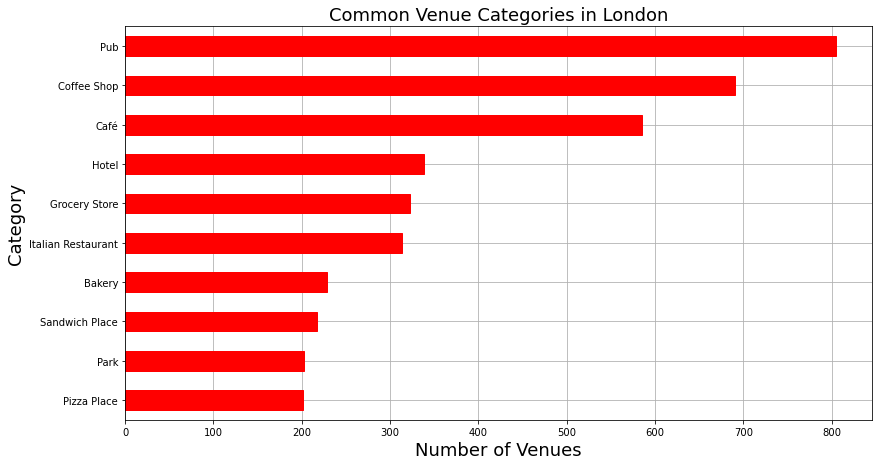

In [88]:
fig, ax = plt.subplots(figsize=(12,6))
london_top_vc = london_venues['Venue Category'].value_counts(normalize=False)
#ax = london_top_vc.head(10).plot(kind='barh', grid=True, color = "skyblue", edgecolor='blue');
ax = london_top_vc.head(10).plot(kind='barh', grid=True, color = "red", edgecolor='red');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in London', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Category", fontsize=18)
fig.savefig('London_most_common_venue.png', dpi=300)

### _3.1.2 Paris_

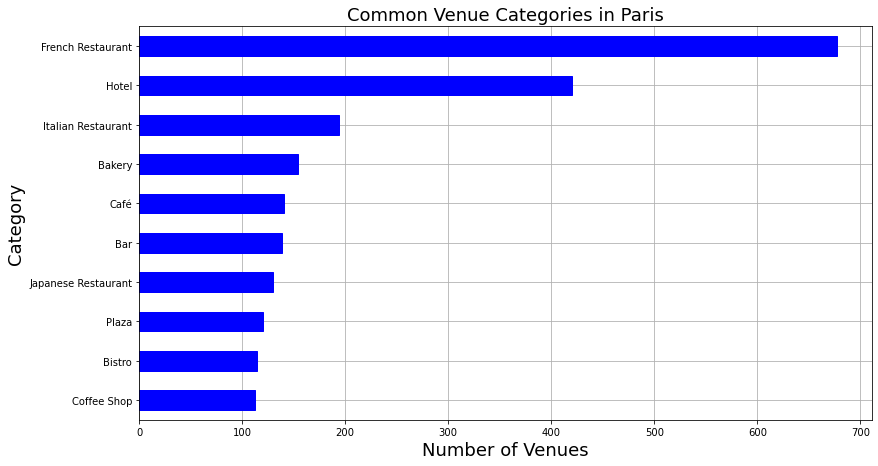

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
paris_top_vc = paris_venues['Venue Category'].value_counts(normalize=False)
#ax = paris_top_vc.head(10).plot(kind='barh', grid=True, color = "#d18cd0", edgecolor='#7a0578');
ax = paris_top_vc.head(10).plot(kind='barh', grid=True, color = 'blue', edgecolor='blue');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Paris', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Category", fontsize=18)
fig.savefig('paris_most_common_venue.png', dpi=300)

## 3.2 Venue Categories in most neighborhoods

### _3.2.1 London_

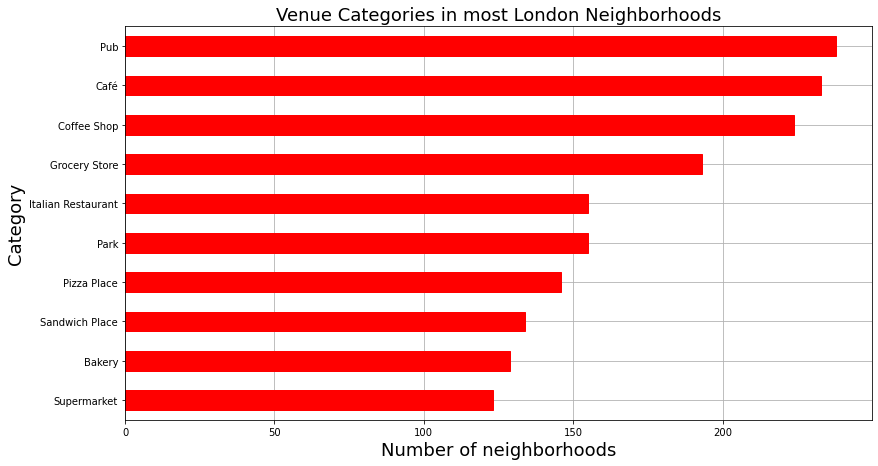

In [90]:
fig, ax = plt.subplots(figsize=(12,6))
london_groupby = london_onehot.groupby('Neighborhood').max().reset_index()
london_sorted = london_groupby.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
#ax = london_sorted.head(10).plot(kind='barh', grid=True, color = "#ffb77d", edgecolor='#eb7413');
ax = london_sorted.head(10).plot(kind='barh', grid=True, color = 'red', edgecolor='red');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most London Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Category", fontsize=18)
fig.savefig('london_venue_in_more_neighborhood.png', dpi=300)

### _3.2.2 Paris_

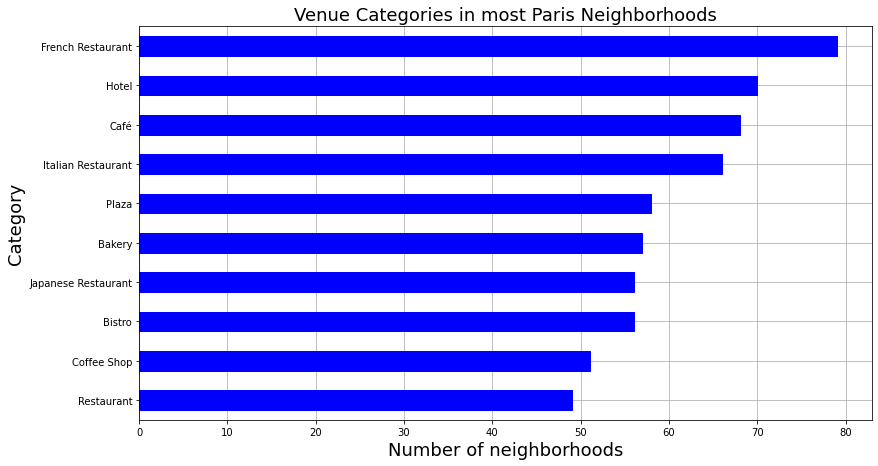

In [91]:
fig, ax = plt.subplots(figsize=(12,6))
paris_groupby = paris_onehot.groupby('Neighborhood').max().reset_index()
paris_sorted = paris_groupby.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
#ax = paris_sorted.head(10).plot(kind='barh', grid=True, color = "#96f76d", edgecolor='#44db04');
ax = paris_sorted.head(10).plot(kind='barh', grid=True, color = 'blue', edgecolor='blue');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most Paris Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Category", fontsize=18)
fig.savefig('paris_venue_in_more_neighborhood.png', dpi=300)

## 3.3 Rare Categories in both cities

### _3.3.1 London Rare Categories_

In [92]:
london_bottom_venue_count = london_venues['Venue Category'].value_counts(normalize=False)
london_bottom_venue_count = london_bottom_venue_count.tail(10).to_frame('Count')
london_bottom_venue_count.index.names = ['Venue Category']
london_bottom_venue_count

,Count
Venue Category,
Caucasian Restaurant,1
Botanical Garden,1
Flea Market,1
Daycare,1
Shop & Service,1
German Restaurant,1
Hungarian Restaurant,1
Comfort Food Restaurant,1
Fishing Store,1


### _3.3.2 Paris Rare Categories_

In [93]:
paris_bottom_venue_count = paris_venues['Venue Category'].value_counts(normalize=False)
paris_bottom_venue_count = paris_bottom_venue_count.tail(10).to_frame('Count')
paris_bottom_venue_count.index.names = ['Venue Category']
paris_bottom_venue_count

,Count
Venue Category,
Kids Store,1
University,1
Laundromat,1
Office,1
Afghan Restaurant,1
Arts & Entertainment,1
Caribbean Restaurant,1
Recreation Center,1
Tourist Information Center,1


## 3.4 Most popular venues for London and Paris

Now let's figure out what are the most popular venus in both cities

In [94]:
columns_london_only = set(london_grouped.columns).difference(set(paris_grouped.columns))
columns_paris_only = set(paris_grouped.columns).difference(set(london_grouped.columns))

In [99]:
london_grouped_ = london_grouped.copy()
london_grouped_['Neighborhood'] = london_grouped_['Neighborhood'].apply(lambda x: x + '_London')
paris_grouped_ = paris_grouped.copy()
paris_grouped_['Neighborhood'] = paris_grouped_['Neighborhood'].apply(lambda x: x + '_Paris')

for c in columns_paris_only:
    london_grouped_[c] = 0
for c in columns_london_only:
    paris_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood'] + sorted(list(london_grouped_.drop('Neighborhood', axis=1).columns), key=str.lower)
london_grouped_ = london_grouped_[all_clmns_sorted]
paris_grouped_ = paris_grouped_[all_clmns_sorted]
    
london_paris_grouped = pd.concat([london_grouped_, paris_grouped_]).reset_index(drop=True)

In [127]:
london_paris_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Columns: 388 entries, Neighborhood to Zoo Exhibit
dtypes: float64(387), object(1)
memory usage: 1.1+ MB


In [101]:
# obtaining the most popular categories for each neighborhood
london_paris_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
london_paris_neighborhoods_categories_sorted['Neighborhood'] = london_paris_grouped['Neighborhood']

for ind in np.arange(london_paris_grouped.shape[0]):
    london_paris_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(london_paris_grouped.iloc[ind, :], num_top_venues)

london_paris_neighborhoods_categories_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood_London,Supermarket,Convenience Store,Train Station,Coffee Shop,Historic Site,Platform,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space
1,Acton_London,Grocery Store,Breakfast Spot,Train Station,Indian Restaurant,Park,Film Studio,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
2,Aldgate_London,Hotel,Gym / Fitness Center,Restaurant,Coffee Shop,Salad Place,Italian Restaurant,Garden,Pub,Cocktail Bar,French Restaurant
3,Aldwych_London,Pub,Sandwich Place,Theater,Hotel,Japanese Restaurant,Café,Chinese Restaurant,Bookstore,Restaurant,Coffee Shop
4,Anerley_London,Supermarket,Grocery Store,Convenience Store,Fast Food Restaurant,Hotel,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit


In [102]:
london_paris_neighborhoods_categories_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Neighborhood            387 non-null    object
 1   1st Most Common Venue   387 non-null    object
 2   2nd Most Common Venue   387 non-null    object
 3   3rd Most Common Venue   387 non-null    object
 4   4th Most Common Venue   387 non-null    object
 5   5th Most Common Venue   387 non-null    object
 6   6th Most Common Venue   387 non-null    object
 7   7th Most Common Venue   387 non-null    object
 8   8th Most Common Venue   387 non-null    object
 9   9th Most Common Venue   387 non-null    object
 10  10th Most Common Venue  387 non-null    object
dtypes: object(11)
memory usage: 33.4+ KB


### _3.4.1 Clustering combined neighborhoods of London and Paris_

In [103]:
# the number of clusters
kclusters = 5
london_paris_grouped_clustering = london_paris_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_london_paris = KMeans(n_clusters=kclusters, random_state=0).fit(london_paris_grouped_clustering)
kmeans_london_paris

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [104]:
# check cluster labels generated for each row in the dataframe
kmeans_london_paris.labels_[0:10]

array([0, 3, 2, 1, 0, 1, 3, 3, 1, 3], dtype=int32)

In [105]:
# add clustering labels
london_paris_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans_london_paris.labels_)

In [106]:
# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
london_paris_merged = london_paris_neighborhoods_categories_sorted.set_index('Neighborhood')
london_paris_merged.iloc[300:310] # check the last columns!

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Winchmore Hill_London,3,Italian Restaurant,Grocery Store,Café,Supermarket,Soccer Field,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market
Wood Green_London,3,Italian Restaurant,Indian Restaurant,Park,Grocery Store,Bar,Dance Studio,Event Space,Exhibit,Falafel Restaurant,Farmers Market
Woodford_London,1,Bar,BBQ Joint,Grocery Store,Pub,Seafood Restaurant,Film Studio,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Woodford Green_London,2,Hotel,Theater,Plaza,Garden,Monument / Landmark,Cocktail Bar,Pub,Restaurant,Tea Room,Boutique
Woodside Park_London,3,Coffee Shop,Bakery,Fast Food Restaurant,Supermarket,Pharmacy,Chinese Restaurant,Thai Restaurant,Theater,Sushi Restaurant,Turkish Restaurant
Woolwich_London,3,Child Care Service,Chinese Restaurant,Convenience Store,Indian Restaurant,Bus Stop,Middle Eastern Restaurant,Grocery Store,Fish & Chips Shop,Zoo Exhibit,Film Studio
Wormwood Scrubs_London,3,Grocery Store,Café,Pub,Gastropub,Pizza Place,Thai Restaurant,Park,Event Space,Gourmet Shop,Greek Restaurant
Amérique_Paris,2,French Restaurant,Supermarket,Pool,Bistro,Park,Bed & Breakfast,Plaza,Café,Zoo Exhibit,Falafel Restaurant
Archives_Paris,2,French Restaurant,Hotel,Coffee Shop,Clothing Store,Bar,Art Gallery,Bookstore,Bistro,Plaza,Cocktail Bar


### _3.4.2 Examining combined clusters_

Let's examine the neighborhoods in each of the five clusters:

#### **Cluster 1 - Both Cities**

In [107]:
Cluster_1LP = london_paris_merged.loc[london_paris_merged['Cluster Labels'] == 0, :]
Cluster_1LP

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Abbey Wood_London,0,Supermarket,Convenience Store,Train Station,Coffee Shop,Historic Site,Platform,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space
Anerley_London,0,Supermarket,Grocery Store,Convenience Store,Fast Food Restaurant,Hotel,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit
Beckenham_London,0,Supermarket,Grocery Store,Convenience Store,Fast Food Restaurant,Hotel,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit
Bexleyheath (also Bexley New Town)_London,0,Supermarket,Convenience Store,Train Station,Coffee Shop,Historic Site,Platform,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space
Childs Hill_London,0,Gym / Fitness Center,Clothing Store,Convenience Store,Hardware Store,Supermarket,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Cricklewood_London,0,Gym / Fitness Center,Clothing Store,Convenience Store,Hardware Store,Supermarket,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Crossness_London,0,Supermarket,Convenience Store,Train Station,Coffee Shop,Historic Site,Platform,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space
Dollis Hill_London,0,Gym / Fitness Center,Clothing Store,Convenience Store,Hardware Store,Supermarket,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Penge_London,0,Supermarket,Grocery Store,Convenience Store,Fast Food Restaurant,Hotel,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit


#### **Cluster 2 - Both Cities**

In [108]:
Cluster_2LP = london_paris_merged.loc[london_paris_merged['Cluster Labels'] == 1, :]
Cluster_2LP

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Aldwych_London,1,Pub,Sandwich Place,Theater,Hotel,Japanese Restaurant,Café,Chinese Restaurant,Bookstore,Restaurant,Coffee Shop
Angel_London,1,Coffee Shop,Pub,Food Truck,Hotel,Gym / Fitness Center,Park,Vietnamese Restaurant,Italian Restaurant,Breakfast Spot,Fish & Chips Shop
Arnos Grove_London,1,Fast Food Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Bus Stop,Pharmacy,Café,Sandwich Place,Turkish Restaurant,Supermarket
Bankside_London,1,Pub,Coffee Shop,Park,Theater,Gym / Fitness Center,Hotel,Garden,Wine Bar,Sandwich Place,Argentinian Restaurant
Barnes_London,1,Food & Drink Shop,Pub,Café,Farmers Market,Park,Coffee Shop,Nature Preserve,Movie Theater,Sports Club,French Restaurant
Barnsbury_London,1,Coffee Shop,Pub,Cocktail Bar,Breakfast Spot,Burger Joint,Café,Restaurant,Vietnamese Restaurant,Yoga Studio,Circus School
Battersea_London,1,Café,Indian Restaurant,Pub,Supermarket,Breakfast Spot,Restaurant,Seafood Restaurant,Thai Restaurant,Theater,Bar
Bedford Park_London,1,Pub,Bakery,Italian Restaurant,Bookstore,Café,Coffee Shop,Pharmacy,Restaurant,Bar,Grocery Store
Belsize Park_London,1,Café,Pub,Bakery,Italian Restaurant,Museum,Ice Cream Shop,American Restaurant,Bookstore,Bed & Breakfast,Coffee Shop


#### **Cluster 3 - Both Cities**

In [109]:
Cluster_3LP = london_paris_merged.loc[london_paris_merged['Cluster Labels'] == 2, :]
Cluster_3LP

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Aldgate_London,2,Hotel,Gym / Fitness Center,Restaurant,Coffee Shop,Salad Place,Italian Restaurant,Garden,Pub,Cocktail Bar,French Restaurant
Barbican_London,2,Gym / Fitness Center,Hotel,Coffee Shop,Boxing Gym,Steakhouse,Art Gallery,Food Truck,Indie Movie Theater,French Restaurant,Sushi Restaurant
Bayswater_London,2,Hotel,Coffee Shop,Café,Pub,Italian Restaurant,Garden,Restaurant,Outdoor Sculpture,French Restaurant,Greek Restaurant
Belgravia_London,2,Hotel,Coffee Shop,Sandwich Place,Theater,Italian Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Pub,Historic Site
Chinatown_London,2,Coffee Shop,French Restaurant,Clothing Store,Hotel,Burger Joint,Juice Bar,Café,Bakery,Cosmetics Shop,Lounge
Earls Court_London,2,Italian Restaurant,Gourmet Shop,Bakery,Grocery Store,Juice Bar,Cocktail Bar,Restaurant,Performing Arts Venue,Lounge,Middle Eastern Restaurant
Fitzrovia_London,2,Coffee Shop,French Restaurant,Clothing Store,Hotel,Burger Joint,Juice Bar,Café,Bakery,Cosmetics Shop,Lounge
Kensington_London,2,Exhibit,Café,Science Museum,Hotel,Garden,Gift Shop,Bar,Restaurant,Bakery,Ice Cream Shop
Kenton_London,2,Hotel,Theater,Plaza,Garden,Monument / Landmark,Cocktail Bar,Pub,Restaurant,Tea Room,Boutique


#### **Cluster 4 - Both Cities**

In [110]:
Cluster_4LP = london_paris_merged.loc[london_paris_merged['Cluster Labels'] == 3, :]
Cluster_4LP

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Acton_London,3,Grocery Store,Breakfast Spot,Train Station,Indian Restaurant,Park,Film Studio,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Archway_London,3,Grocery Store,Coffee Shop,Pizza Place,Pub,Italian Restaurant,Vegetarian / Vegan Restaurant,Park,Pet Store,Bar,Farmers Market
Arkley_London,3,Coffee Shop,Grocery Store,Juice Bar,Café,Argentinian Restaurant,Salon / Barbershop,Pharmacy,Pizza Place,Platform,Restaurant
Balham_London,3,Grocery Store,Coffee Shop,Pub,Indian Restaurant,Bakery,Fast Food Restaurant,Portuguese Restaurant,Steakhouse,Beer Store,Caucasian Restaurant
Barnet Gate_London,3,Coffee Shop,Grocery Store,Juice Bar,Café,Argentinian Restaurant,Salon / Barbershop,Pharmacy,Pizza Place,Platform,Restaurant
Beckton_London,3,Café,Hotel,Science Museum,Diner,Beach,Grocery Store,Gym,Bar,Scenic Lookout,Middle Eastern Restaurant
Bellingham_London,3,Grocery Store,Discount Store,Furniture / Home Store,Train Station,Turkish Restaurant,Pizza Place,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
Bethnal Green_London,3,Coffee Shop,Café,Pub,Brewery,Convenience Store,Social Club,Furniture / Home Store,Fast Food Restaurant,Falafel Restaurant,Park
Blackheath Royal Standard_London,3,Fried Chicken Joint,Pub,Fish & Chips Shop,Grocery Store,Polish Restaurant,Hotel,Train Station,Italian Restaurant,Café,Exhibit


#### **Cluster 5 - Both Cities**

In [111]:
Cluster_5LP = london_paris_merged.loc[london_paris_merged['Cluster Labels'] == 4, :]
Cluster_5LP

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Eltham_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
Falconwood_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
Longlands_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
Middle Park_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
Mottingham_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
New Eltham_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant
Well Hall_London,4,Construction & Landscaping,Golf Course,Historic Site,Bus Stop,Park,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant


In [112]:
clust_cats = []
clusters = [Cluster_1LP, Cluster_2LP, Cluster_3LP, Cluster_4LP, Cluster_5LP]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('London'):
            nn = n[:-7]
            clust_cats[i].extend(list(london_venues[london_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-6]
            clust_cats[i].extend(list(paris_venues[paris_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [113]:
! pip install tabulate
from tabulate import tabulate

  Using cached https://files.pythonhosted.org/packages/c4/f4/770ae9385990f5a19a91431163d262182d3203662ea2b5739d0fcfc080f1/tabulate-0.8.7-py3-none-any.whl


In [114]:
for i in range(kclusters):
    df = pd.DataFrame(data=clust_cats[i], columns=["% of venues"])
#     print(type(clust_cats[i]))
#     df = pd.DataFrame(data=clust_cats[i])
#     print(df.head(7))
    print("\n\n\t Cluster {}".format(i+1))
    print(tabulate(df.head(7), headers = 'keys', tablefmt = 'fancy_grid'))



	 Cluster 1
╒══════════════════════╤═══════════════╕
│                      │   % of venues │
╞══════════════════════╪═══════════════╡
│ Supermarket          │      27.8689  │
├──────────────────────┼───────────────┤
│ Convenience Store    │      16.3934  │
├──────────────────────┼───────────────┤
│ Train Station        │       6.55738 │
├──────────────────────┼───────────────┤
│ Platform             │       6.55738 │
├──────────────────────┼───────────────┤
│ Historic Site        │       6.55738 │
├──────────────────────┼───────────────┤
│ Coffee Shop          │       6.55738 │
├──────────────────────┼───────────────┤
│ Fast Food Restaurant │       4.91803 │
╘══════════════════════╧═══════════════╛


	 Cluster 2
╒════════════════════╤═══════════════╕
│                    │   % of venues │
╞════════════════════╪═══════════════╡
│ Pub                │      10.7637  │
├────────────────────┼───────────────┤
│ Coffee Shop        │       5.98383 │
├────────────────────┼───────────────┤
│ 

----

In [115]:
n_counts = []
for c in clusters:
    london_c = 0
    paris_c = 0
    for n in c.index.values:
        if n.endswith('London'):
            london_c += 1
        else:
            paris_c += 1
    n_counts.append((london_c, paris_c))

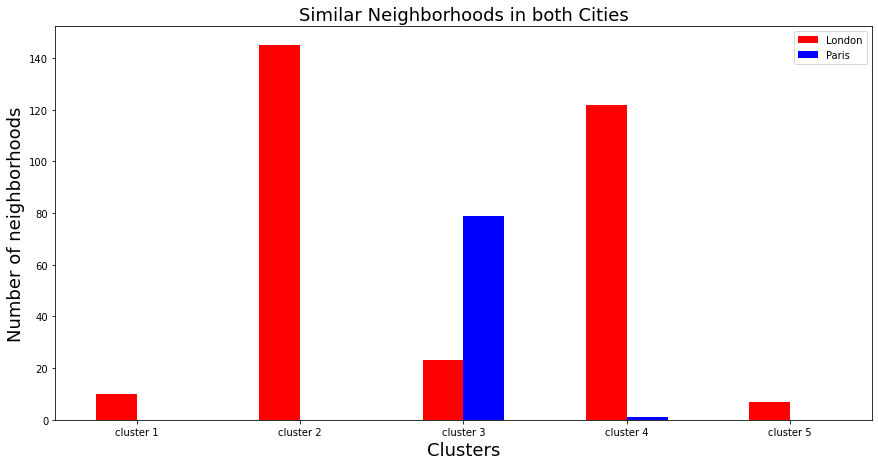

In [116]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'London': [x[0] for x in n_counts],
    'Paris': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=(12,6))
#city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
city_c_df.plot(kind='bar', color=['red', 'blue'], rot=0, ax=ax)

# plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
plt.tight_layout()
plt.title('Similar Neighborhoods in both Cities', fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylabel("Number of neighborhoods", fontsize=18)
fig.savefig('similar_neighborhoods.png', dpi=300)